### Load Libraries

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Folders

In [2]:
train_folder = '../Dataset/CASIA-FASD/train_release'
test_folder = '../Dataset/CASIA-FASD/test_release'

### Video Extraction

In [3]:
def extract_frames(video_path, num_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate interval to sample evenly from the video
    interval = total_frames // num_frames

    for i in range(num_frames):
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()

        if ret:
            # Resize the frame if needed (e.g., 224x224)
            frame = cv2.resize(frame, (176, 176))
            # Append the frame to the list (in RGB format)
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            break

    cap.release()

    # Convert list of frames to a numpy array of shape (num_frames, height, width, channels)
    return np.array(frames)

def extract_videos(folder_path):
    video_list, label_list = [], []
    for folder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder)
        for video in os.listdir(subfolder_path):
            video_path = os.path.join(subfolder_path, video)
            # print(video_path)
            vid = extract_frames(video_path, 8) # num_frames=8, change if needed

            if video == "1.avi" or video == "2.avi" or video == "HR_1.avi":
                label = 1
            else:
                label = 0

            video_list.append(vid)
            label_list.append(label)

    return np.array(video_list), np.array(label_list)

In [4]:
# train_videos, train_labels = extract_videos(train_folder)
# test_videos, test_labels = extract_videos(test_folder)

In [5]:
train_videos_path = './Face Liveness/Face features/3dcnn/train_videos176.npy'
test_videos_path = './Face Liveness/Face features/3dcnn/test_videos176.npy'
train_labels_path = './Face Liveness/Face features/train_labels.npy'
test_labels_path = './Face Liveness/Face features/test_labels.npy'

In [6]:
# np.save(train_videos_path, train_videos)
# np.save(test_videos_path, test_videos)
# np.save(train_labels_path, train_labels)
# np.save(test_labels_path, test_labels)

In [7]:
train_videos = np.load(train_videos_path)
test_videos = np.load(test_videos_path)

In [8]:
print(f'train video shape : {train_videos.shape}')

train video shape : (240, 8, 176, 176, 3)


In [9]:
train_labels = np.load(train_labels_path)
test_labels = np.load(test_labels_path)

In [10]:
print(f'test video shape  : {test_videos.shape}')

test video shape  : (360, 8, 176, 176, 3)


Data diambil dari dataset CASIA-FASD. Data train terdiri dari 20 identitas dan data test terdiri dari 30 identitas. Masing-masing identitas terdiri dari 12 video (4 genuine dan 8 spoof). 

#### Sample data show

In [11]:
import matplotlib.pyplot as plt

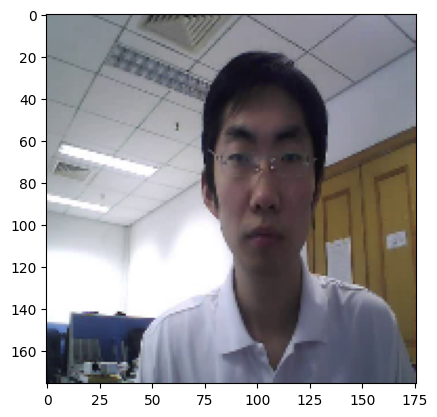

(176, 176, 3)


In [12]:
plt.imshow(train_videos[0][0])
plt.show()
print(train_videos[0][0].shape)

In [13]:
print(train_videos.shape)

(240, 8, 176, 176, 3)


### 3D CNN

In [14]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten
from keras.models import Sequential
from keras.layers import (Activation, Conv3D, Dropout, Flatten, MaxPooling3D)
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

In [15]:
def build_3d_cnn():
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(train_videos[0].shape), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('softmax'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))  # Adjusted kernel size
    model.add(Activation('relu'))
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))  # Adjusted kernel size
    model.add(Activation('softmax'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

    return model


In [16]:
cnn3d = build_3d_cnn()

In [17]:
cnn3d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 176, 176, 32)   2624      
                                                                 
 activation (Activation)     (None, 8, 176, 176, 32)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 176, 176, 32)   27680     
                                                                 
 activation_1 (Activation)   (None, 8, 176, 176, 32)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 88, 88, 32)    0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 88, 88, 64)     16448     
                                                        

### Extract features

In [18]:
from tensorflow.keras.models import Model

In [19]:
def extract_features(cnn_model, data):
    # Use the CNN model up to the last Flatten layer for feature extraction
    feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-1].output)
    
    # Extract features for all videos
    features = feature_extractor.predict(data)
    return features

In [20]:
# Extract features from the training set
train_features = extract_features(cnn3d, train_videos)

6/8 [=====================>........] - ETA: 0s

ResourceExhaustedError: Graph execution error:

Detected at node 'model/activation_1/Softmax' defined at (most recent call last):
    File "c:\Users\andre\anaconda3\envs\Python\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\andre\anaconda3\envs\Python\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\andre\anaconda3\envs\Python\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\andre\anaconda3\envs\Python\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\andre\anaconda3\envs\Python\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\andre\AppData\Local\Temp\ipykernel_28684\1865889614.py", line 2, in <module>
      train_features = extract_features(cnn3d, train_videos)
    File "C:\Users\andre\AppData\Local\Temp\ipykernel_28684\3975333670.py", line 6, in extract_features
      features = feature_extractor.predict(data)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\layers\core\activation.py", line 59, in call
      return self.activation(inputs)
    File "c:\Users\andre\anaconda3\envs\Python\lib\site-packages\keras\activations.py", line 84, in softmax
      output = tf.nn.softmax(x, axis=axis)
Node: 'model/activation_1/Softmax'
OOM when allocating tensor with shape[32,8,176,176,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/activation_1/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_263]

In [21]:
test_features = extract_features(cnn3d, test_videos)

12/12 [==============================] - 4s 357ms/step


In [22]:
print(train_features.shape)
print(test_features.shape)

(240, 204800)
(360, 204800)


In [23]:
# from sklearn.svm import SVC

In [24]:
# from sklearn.metrics import accuracy_score, classification_report

# # Train an SVM classifier
# svm_classifier = SVC(kernel='linear')
# svm_classifier.fit(train_features, train_labels)

# # Test the SVM classifier on the test set
# svm_predictions = svm_classifier.predict(test_features)

# # Evaluate the classifier
# accuracy = accuracy_score(test_labels, svm_predictions)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Print detailed classification report
# print(classification_report(test_labels, svm_predictions))

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train an XGB classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_features, train_labels)

# Test the SVM classifier on the test set
xgb_predictions = xgb_classifier.predict(test_features)

# Evaluate the classifier
accuracy = accuracy_score(test_labels, xgb_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification report
print(classification_report(test_labels, xgb_predictions))

c:\Users\andre\anaconda3\envs\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 83.89%
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       240
           1       0.85      0.62      0.72       120

    accuracy                           0.84       360
   macro avg       0.84      0.79      0.80       360
weighted avg       0.84      0.84      0.83       360

